# Week 8 Assignment
Darrell Silva

For this exercise, I am giong to test various learning rates in Deep Q-Learning on the CartPole v0 environment. I will be testing learing rates 1, 0.1, 0.01, 0.001, and 0.0001 using a simple for loop. After observing how manual learning rate adjustments perform, I will attempt a time-based learning rate schedule which should in theory be a superior method.

### Import libraries

In [5]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam, SGD

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=True)

### Train and plot
Train a DQN for each learning rate and plot the results.

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


C:\Users\dsilva01\AppData\Roaming\Python\Python38\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


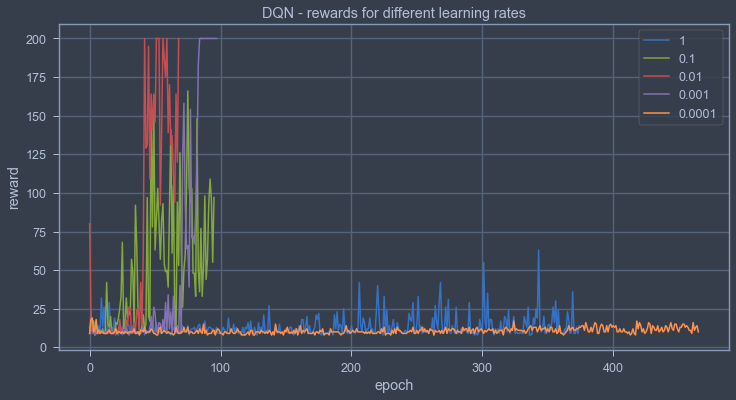

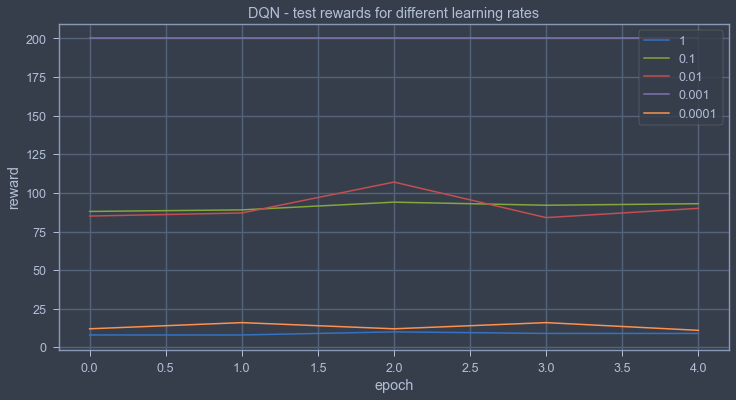

In [2]:
lrs = [1, 0.1, 0.01, 0.001, 0.0001]
histories = {}
tests = {}

for lr in lrs:
    ENV_NAME = 'CartPole-v0'
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions, activation='linear'))

    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)

    dqn = DQNAgent(
        model=model, 
        nb_actions=nb_actions, 
        memory=memory, 
        nb_steps_warmup=10,
        target_model_update=1e-2, 
        policy=policy,
    )
    dqn.compile(Adam(lr=lr), metrics=['mae'])

    history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=0)
    rewards = history.history['episode_reward']
    histories[lr] = rewards
    
    test = dqn.test(env, nb_episodes=5, visualize=False, verbose=0)
    test_rewards = test.history['episode_reward']
    tests[lr] = test_rewards
     
plt.figure(figsize=(12,6))
for lr in histories.keys():
    plt.plot(range(len(histories[lr])), histories[lr], label=lr)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('DQN - rewards for different learning rates')
plt.show()

plt.figure(figsize=(12,6))
for lr in tests.keys():
    plt.plot(range(len(tests[lr])), tests[lr], label=lr)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('DQN - test rewards for different learning rates')
plt.show()

### Manual Learning Rate Adjustment Conclusions
Learning rate 0.001 has a clear advantage over the others. There seems to be some sort of early stopping in play due to the limited number of epochs reached by learning rates 0.01 and 0.001. As you can see in the test rewards plot, learning rate 0.001 consistently reached 200 steps while 0.01 only reached 200 once. The others were either too large or too small of learning rates as shown by their low test rewards.

Although learning rate 0.001 was the original learning rate used in the example and I didn't technically improve the model, this exercise still served as a valuable learning experience regarding Deep Q Learning and learning rates.

# Time-Based Learning Rate Schedule
I will be using the SGD optimizer since time-based learning rate schedule functionality is already built into it. The three variables I have to play with are number of epochs, initial learning rate, and momentum. I will adjust each individually and observe their performance.

#### Initial learning rate adjustments
I will be trying this with learning rates of 1, 0.1, 0.01, and 0.001. Given the learning rate will decrease, it comes recommended to start with a larger learning rate. Epochs and momentum will stay at 50 and 0.8 respectively.

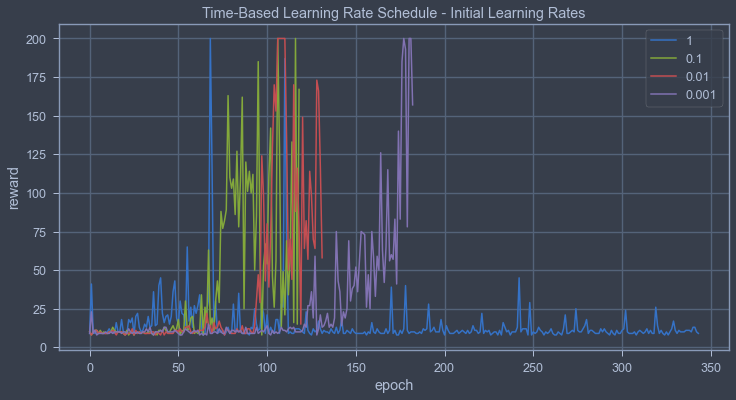

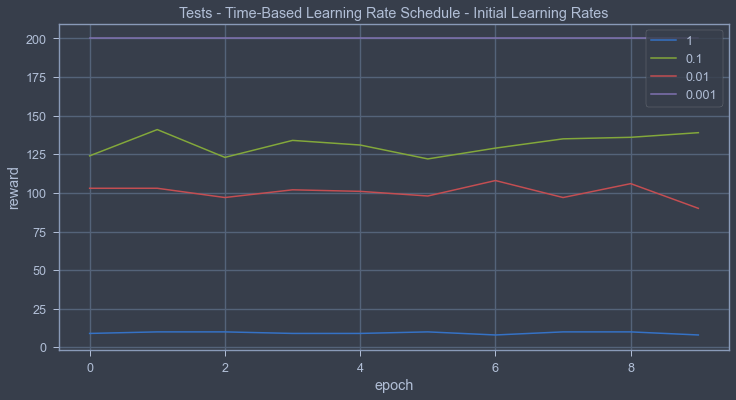

In [23]:
lrs = [1, 0.1, 0.01, 0.001]
histories = {}
tests = {}

for learning_rate in lrs:
    ENV_NAME = 'CartPole-v0'
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions, activation='linear'))

    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)

    dqn = DQNAgent(
        model=model, 
        nb_actions=nb_actions, 
        memory=memory, 
        nb_steps_warmup=10,
        target_model_update=1e-2, 
        policy=policy,
    )
    epochs = 50
    # learning_rate = 0.1
    decay_rate = learning_rate / epochs
    momentum = 0.8
    
    optimizer = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    dqn.compile(optimizer, metrics=['mae'])

    history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=0)
    rewards = history.history['episode_reward']
    histories[learning_rate] = rewards
    
    test = dqn.test(env, nb_episodes=10, visualize=False, verbose=0)
    test_rewards = test.history['episode_reward']
    tests[learning_rate] = test_rewards
     
plt.figure(figsize=(12,6))
for x in histories.keys():
    plt.plot(range(len(histories[x])), histories[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Time-Based Learning Rate Schedule - Initial Learning Rates')
plt.show()

plt.figure(figsize=(12,6))
for x in tests.keys():
    plt.plot(range(len(tests[x])), tests[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Tests - Time-Based Learning Rate Schedule - Initial Learning Rates')
plt.show()

### Initial learning-rate adjustment conclusions
The previously found optimized learning rate of 0.001 prevailed yet again (surprise). However, this time around, the other learning rates aside from 1 had better performance. This is a much more convienent method than manually trying various learning rates.

#### Epoch adjustments
Adjusting the epochs that factor into the learning rate is adjusting the denominator of the decay rate, so a larger epoch number increases the decay rate. I will be trying 10, 50, and 100.

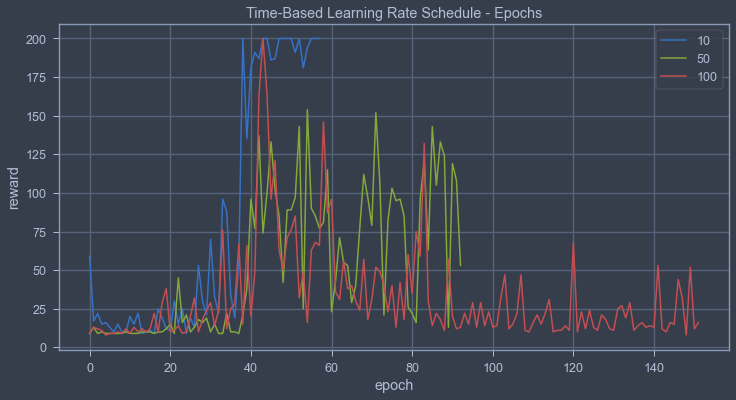

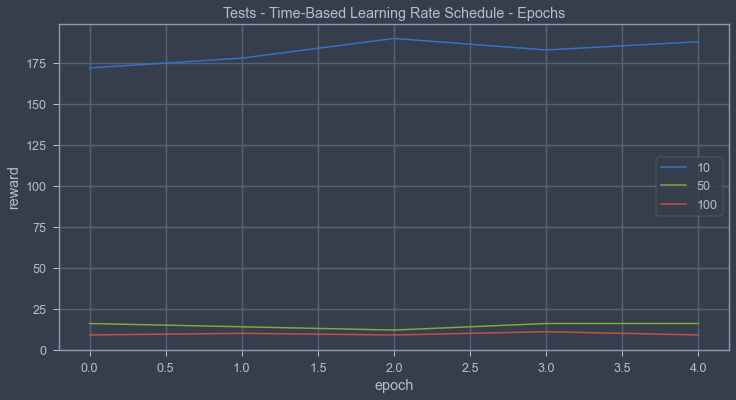

In [24]:
epochs_list = [10, 50, 100]
histories = {}
tests = {}

for epochs in epochs_list:
    ENV_NAME = 'CartPole-v0'
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions, activation='linear'))

    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)

    dqn = DQNAgent(
        model=model, 
        nb_actions=nb_actions, 
        memory=memory, 
        nb_steps_warmup=10,
        target_model_update=1e-2, 
        policy=policy,
    )
#     epochs = 50
    learning_rate = 0.1
    decay_rate = learning_rate / epochs
    momentum = 0.8
    
    optimizer = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    dqn.compile(optimizer, metrics=['mae'])

    history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=0)
    rewards = history.history['episode_reward']
    histories[epochs] = rewards
    
    test = dqn.test(env, nb_episodes=5, visualize=False, verbose=0)
    test_rewards = test.history['episode_reward']
    tests[epochs] = test_rewards
     
plt.figure(figsize=(12,6))
for x in histories.keys():
    plt.plot(range(len(histories[x])), histories[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Time-Based Learning Rate Schedule - Epochs')
plt.show()

plt.figure(figsize=(12,6))
for x in tests.keys():
    plt.plot(range(len(tests[x])), tests[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Tests - Time-Based Learning Rate Schedule - Epochs')
plt.show()

### Epoch adjustment conclusions
I was initially expecting a higher epoch number to receive more rewards. The above graphs show that the lower number 10 performed the best. I believe this means the model had more time to train for each given learning rate.

#### Momentum adjustments
The momentum is essentially how big of steps the learning rate takes in a given direction. I will choose a lower, medium, and higher momentum for this test (0.3, 0.5, 0.8).

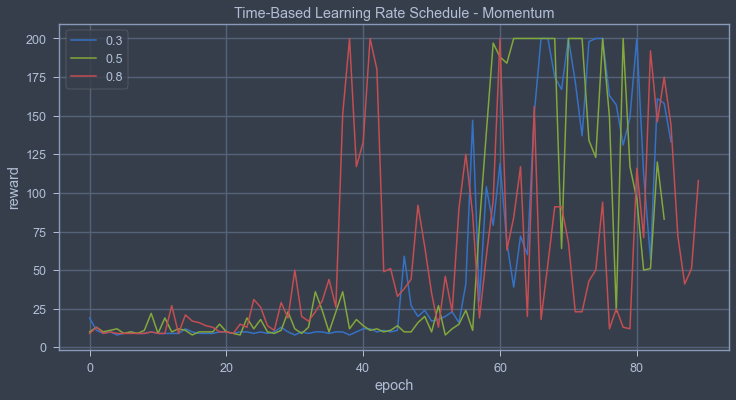

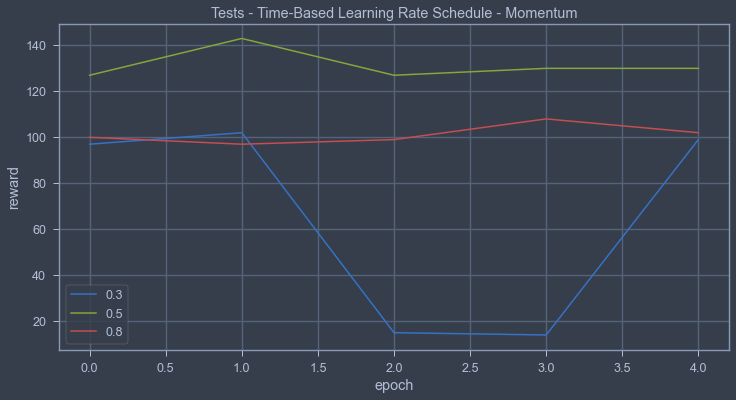

In [25]:
momentum_list = [0.3, 0.5, 0.8]
histories = {}
tests = {}

for momentum in momentum_list:
    ENV_NAME = 'CartPole-v0'
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions, activation='linear'))

    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)

    dqn = DQNAgent(
        model=model, 
        nb_actions=nb_actions, 
        memory=memory, 
        nb_steps_warmup=10,
        target_model_update=1e-2, 
        policy=policy,
    )
    epochs = 50
    learning_rate = 0.1
    decay_rate = learning_rate / epochs
#     momentum = 0.8
    
    optimizer = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    dqn.compile(optimizer, metrics=['mae'])

    history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=0)
    rewards = history.history['episode_reward']
    histories[momentum] = rewards
    
    test = dqn.test(env, nb_episodes=5, visualize=False, verbose=0)
    test_rewards = test.history['episode_reward']
    tests[momentum] = test_rewards
     
plt.figure(figsize=(12,6))
for x in histories.keys():
    plt.plot(range(len(histories[x])), histories[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Time-Based Learning Rate Schedule - Momentum')
plt.show()

plt.figure(figsize=(12,6))
for x in tests.keys():
    plt.plot(range(len(tests[x])), tests[x], label=x)
plt.legend()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.title('Tests - Time-Based Learning Rate Schedule - Momentum')
plt.show()

### Momentum adjustment conclusions
Despite reading that a higher momentum rate is recommended, the middle-of-the-road value of 0.5 performed the best during this test. However, 0.8 did reach rewards of 200 in training quicker than the others which makes sense because it essentially found the right learning rate and made big jumps in that direction. 

# Overall time-based learning rate schedule conclusions
I do find this method to be superior than manual learning rate adjustments. The main takeaway from my tests is while you can improve performance adjusting one variable of the equation at a time, you can probably go farther with a mix of variable adjustments.